# Import Library

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

# Load Data

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Data Exploration

In [4]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train_df)

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [5]:
missing_data(test_df)

,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [6]:
def get_categories(data, val):
    tmp = data[val].value_counts()
    return pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index()

In [7]:
def get_survived_categories(data, val):
    tmp = data.groupby('Survived')[val].value_counts()
    return pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index()

In [8]:
def draw_trace_bar(data_df,color='Blue'):
    trace = go.Bar(
            x = data_df['index'],
            y = data_df['Number'],
            marker=dict(color=color),
            text=data_df['index']
        )
    return trace

In [9]:
def plot_two_bar(data_df1, data_df2, title1, title2, xlab, ylab):
    trace1 = draw_trace_bar(data_df1, color='Blue')
    trace2 = draw_trace_bar(data_df2, color='Lightblue')
    
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=(title1,title2))
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    
    fig['layout']['xaxis'].update(title = xlab)
    fig['layout']['xaxis2'].update(title = xlab)
    fig['layout']['yaxis'].update(title = ylab)
    fig['layout']['yaxis2'].update(title = ylab)
    fig['layout'].update(showlegend=False)
    

    iplot(fig, filename='draw_trace')

In [10]:
def plot_survived_bar(data_df, var, ytitle= 'Number of passengers',title= 'Number of survived and not survived passengers by {}'):
    dfS = data_df[data_df['Survived']==1]
    dfN = data_df[data_df['Survived']==0]

    traceS = go.Bar(
        x = dfS[var],y = dfS['Number'],
        name='Survived',
        marker=dict(color="Blue"),
        text=dfS['Number']
    )
    traceN = go.Bar(
        x = dfN[var],y = dfN['Number'],
        name='Not survived',
        marker=dict(color="Red"),
        text=dfS['Number']
    )
    
    data = [traceS, traceN]
    layout = dict(title = title.format(var),
          xaxis = dict(title = var, showticklabels=True), 
          yaxis = dict(title = ytitle),
          hovermode = 'closest'
    )
    fig = dict(data=data, layout=layout)
   
    iplot(fig, filename='draw_trace')

In [11]:
plot_two_bar(get_categories(train_df,'Sex'), get_categories(test_df,'Sex'), 
             'Train data', 'Test data',
             'Sex', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [12]:
plot_survived_bar(get_survived_categories(train_df,'Sex'), 'Sex')

In [13]:
plot_two_bar(get_categories(train_df,'Age'), get_categories(test_df,'Age'), 
             'Train data', 'Test data',
             'Age', 'Number of passengers')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [14]:
plot_survived_bar(get_survived_categories(train_df,'Age'), 'Age')

In [15]:
plot_survived_bar(get_survived_categories(train_df,'SibSp'), 'SibSp')

In [16]:
plot_survived_bar(get_survived_categories(train_df,'Parch'), 'Parch')

In [17]:
train_df['Ticket'].value_counts().head(10)

347082          7
CA. 2343        7
1601            7
CA 2144         6
347088          6
3101295         6
S.O.C. 14879    5
382652          5
4133            4
2666            4
Name: Ticket, dtype: int64

In [18]:
train_df['Cabin'].value_counts().head(10)

G6             4
C23 C25 C27    4
B96 B98        4
F2             3
F33            3
C22 C26        3
D              3
E101           3
E8             2
E44            2
Name: Cabin, dtype: int64

In [19]:
train_df['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

# Feature engineering

In [20]:
all_df = [train_df, test_df]

In [21]:
for dataset in all_df:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [22]:
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [23]:
for dataset in all_df:
    #unify `Miss`
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    #unify `Mrs`
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [24]:
for dataset in all_df:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

In [25]:
train_df[['Title', 'Sex', 'Survived']].groupby(['Title', 'Sex'], as_index=False).mean()

,Title,Sex,Survived
0,Master,male,0.575000
1,Miss,female,0.702703
2,Mr,male,0.156673
3,Mrs,female,0.793651
4,Rare,female,1.000000
5,Rare,male,0.250000


In [26]:
plot_survived_bar(get_survived_categories(train_df,'Title'), 'Title')

In [27]:
for dataset in all_df:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [28]:
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [29]:
for dataset in all_df:
    dataset['Surname'] = dataset.Name.str.extract('([A-Za-z]+)\,', expand=False)

In [30]:
tmp = train_df.groupby(['Surname'])['Survived'].value_counts()
df = pd.DataFrame(data={'Size of group with same Surname': tmp.values}, index=tmp.index).reset_index().sort_values(['Size of group with same Surname', 'Surname'], ascending=False)

In [31]:
tmp = df.groupby(['Size of group with same Surname'])['Survived'].value_counts()
df = pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index().sort_values(['Size of group with same Surname', 'Survived'], ascending=False)
df

,Size of group with same Surname,Survived,Number
10,7,0,2
9,6,0,3
8,5,0,1
7,4,1,2
6,4,0,4
5,3,1,6
4,3,0,13
2,2,1,44
3,2,0,37
1,1,1,228


In [32]:
for dataset in all_df:
    dataset['Deck'] = dataset.Cabin.str.extract('^([A-Za-z]+)', expand=False)

In [33]:
train_df[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean()

,Deck,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,T,0.000000


In [34]:
for dataset in all_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [35]:
age_aprox = np.zeros((2,3))
for dataset in all_df:
    for i in range(0, 2):
        for j in range(0, 3):
            aprox_age = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_aprox[i,j] = aprox_age.median()
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),'Age'] = \
                    age_aprox[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [36]:
tmp = train_df.groupby(['Title', 'Pclass'])['Survived'].value_counts()
df = pd.DataFrame(data={'Passengers': tmp.values}, index=tmp.index).reset_index()
df

,Title,Pclass,Survived,Passengers
0,Master,1,1,3
1,Master,2,1,9
2,Master,3,0,17
3,Master,3,1,11
4,Miss,1,1,46
5,Miss,1,0,2
6,Miss,2,1,33
7,Miss,2,0,2
8,Miss,3,0,51
9,Miss,3,1,51


In [37]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in all_df:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [38]:
for dataset in all_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

In [39]:
for dataset in all_df:
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [40]:
for dataset in all_df:
    dataset.loc[ dataset['FamilySize'] <= 1, 'FamilySize'] = 0
    dataset.loc[(dataset['FamilySize'] > 1) & (dataset['FamilySize'] <= 4), 'FamilySize'] = 1
    dataset.loc[ dataset['FamilySize'] > 4, 'FamilySize'] = 2

In [41]:
for dataset in all_df:
    dataset['Class*Age'] = dataset['Pclass'] * dataset['Age']

In [42]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Surname,Deck,Class*Age
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0.0,NaN,S,1,1,Braund,NaN,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,PC 17599,3.0,C85,C,3,1,Cumings,C,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,STON/O2. 3101282,1.0,NaN,S,2,0,Heikkinen,NaN,3


In [43]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,Surname,Deck,Class*Age
0,892,3,"Kelly, Mr. James",0,2,0,0,330911,0.0,NaN,Q,1,0,Kelly,NaN,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,363272,0.0,NaN,S,3,1,Wilkes,NaN,6
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,240276,1.0,NaN,Q,1,0,Myles,NaN,6


In [44]:
train, valid = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True )

In [45]:
predictors = ['FamilySize', 'Title', 'Class*Age']
target = 'Survived'

In [46]:
clf = RandomForestClassifier(n_jobs=4, 
                             random_state=42,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)

In [47]:
train_X = train[predictors]
train_Y = train[target].values
valid_X = valid[predictors]
valid_Y = valid[target].values

In [48]:
rf_clf = clf.fit(train_X, train_Y)

In [49]:
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=42, verbose=False,
            warm_start=False)

In [50]:
preds = clf.predict(valid_X)

In [51]:
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()   

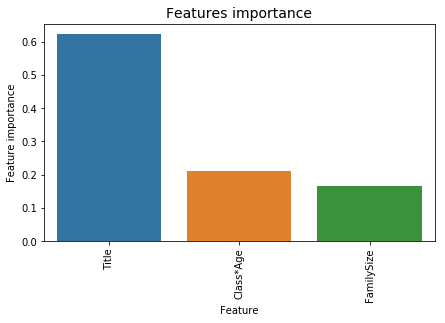

In [52]:
plot_feature_importance()

In [53]:
clf.score(train_X, train_Y)
acc = round(clf.score(train_X, train_Y) * 100, 2)
print("RandomForest accuracy (train set):", acc)

RandomForest accuracy (train set): 84.13


In [54]:
clf.score(valid_X, valid_Y)
acc = round(clf.score(valid_X, valid_Y) * 100, 2)
print("RandomForest accuracy (validation set):", acc)

RandomForest accuracy (validation set): 81.56


In [55]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.82      0.88      0.85       105
    Survived       0.81      0.73      0.77        74

   micro avg       0.82      0.82      0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



# Submission

In [56]:
test_X = test_df[predictors]
pred_Y = clf.predict(test_X)

In [57]:
submission = pd.DataFrame({"PassengerId": test_df["PassengerId"],"Survived": pred_Y})
submission.to_csv('submission.csv', index=False)